In [ ]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [ ]:
import torch
from glob import glob
import os
import random
from collections import Counter

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = r"https://drive.google.com/drive/folders/1OOxBCs8AQpw41oeFo7nf2cf3VtH9Illp?usp=drive_link"
image_size = (224, 224)

# Get all subdirectory paths in the dataset path
subfolders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Iterate through each subdirectory
for folder in subfolders:
    # Get all image paths in the current folder
    image_files = glob(os.path.join(folder, "*.jpg"))
    # Assign label based on folder name (e.g., "Normal" or "Stroke")
    label = os.path.basename(folder)
    # Extend the image paths list and labels list
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))

# Combine the paths and labels into a list of tuples for shuffling
data = list(zip(image_paths, labels))
random.shuffle(data)

# Unzip the data
image_paths, labels = zip(*data)

# Get unique classes and their counts
class_counts = Counter(labels)
classes = list(class_counts.keys())
num_classes = len(classes)

# Print the list of classes and their counts
print(f"Classes: {classes}")
print(f"Number of classes: {num_classes}")
print("Class counts:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

# Split the data into training and testing sets
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]
train_labels = labels[:train_size]
test_labels = labels[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


FileNotFoundError: [Errno 2] No such file or directory: 'https://drive.google.com/drive/folders/1OOxBCs8AQpw41oeFo7nf2cf3VtH9Illp?usp=drive_link'

In [ ]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}

    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        label_index = self.labels_to_index[label]

        if self.transform:
            img = self.transform(img)

        return img, label_index,label


    def __len__(self):
        return len(self.paths)


    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [ ]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self,num_classes):
        super(CNN_Model,self).__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)




    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming these lists are defined somewhere in your code
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_score = float("inf")
n_epochs = 30
tolerance = 0

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)  # Adjust based on the number of items your DataLoader returns
            labels = batch[1].to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()

    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"cnn_model{epoch+1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)



Epoch 0,   Train Loss: 2.9081, Train Accuracy: 20.50%
Eval Loss: 2.3617, Eval Accuracy: 34.34%
######################################################################
Epoch 1,   Train Loss: 1.9632, Train Accuracy: 42.64%
Eval Loss: 1.7423, Eval Accuracy: 50.84%
######################################################################
Epoch 2,   Train Loss: 1.5150, Train Accuracy: 53.87%
Eval Loss: 1.4316, Eval Accuracy: 63.30%
######################################################################
Epoch 3,   Train Loss: 1.2341, Train Accuracy: 62.13%
Eval Loss: 1.3534, Eval Accuracy: 66.67%
######################################################################
Epoch 4,   Train Loss: 1.0773, Train Accuracy: 66.34%
Eval Loss: 1.4128, Eval Accuracy: 66.67%
######################################################################
Epoch 5,   Train Loss: 0.8924, Train Accuracy: 72.71%
Eval Loss: 1.2722, Eval Accuracy: 67.51%
######################################################################
Epoc

<Figure size 2000x800 with 0 Axes>

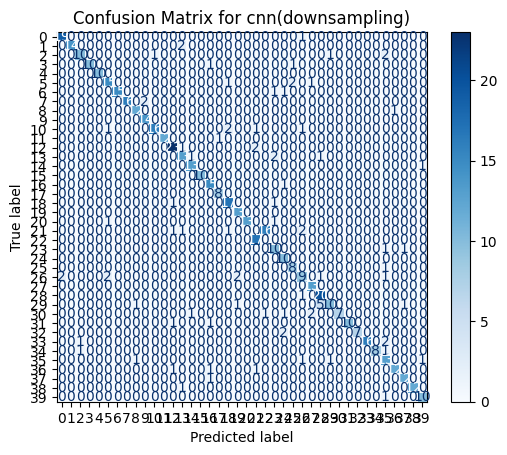

Classification Report for cnn(downsampling):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      0.88      0.93        16
           2       0.83      0.71      0.77        14
           3       1.00      0.83      0.91        12
           4       1.00      1.00      1.00        10
           5       0.79      0.79      0.79        19
           6       1.00      0.88      0.94        17
           7       1.00      0.89      0.94        18
           8       0.86      0.92      0.89        13
           9       0.88      1.00      0.93        14
          10       0.94      0.76      0.84        21
          11       1.00      0.92      0.96        13
          12       0.85      0.88      0.87        26
          13       0.72      0.76      0.74        17
          14       0.87      0.93      0.90        14
          15       1.00      1.00      1.00        10
          16       0.79      0.94   

In [ ]:
# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

# Set the figure size
plt.figure(figsize=(20, 8))  # Adjust width and height as needed

# Create and plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Set plot title and show plot
plt.title("Confusion Matrix for cnn(downsampling)")
plt.show()


# Print classification report
print("Classification Report for cnn(downsampling):")
print(classification_report(true_labels, preds))

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the classes
Classes = ['Aloevera', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Avacado',
           'Bamboo', 'Basale', 'Betel', 'Betel_Nut', 'Brahmi',
           'Castor', 'Curry_Leaf',
           'Doddapatre', 'Ekka', 'Ganike', 'Gauva', 'Geranium',
           'Henna', 'Hibiscus', 'Honge', 'Insulin',
           'Jasmine', 'Lemon', 'Lemon_grass', 'Mango', 'Mint',
           'Nagadali', 'Neem', 'Nithyapushpa', 'Nooni', 'Pappaya', 'Pepper',
           'Pomegranate', 'Raktachandini', 'Rose', 'Sapota', 'Tulasi', 'Wood_sorel']

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model class (same as the one used during training)
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(6*6*128, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the trained model
model = MyModel(num_classes=len(Classes))  # Ensure num_classes matches the length of Classes
model.load_state_dict(torch.load("/kaggle/working/cnn_model9.pt"))  # Make sure the model path is correct
model = model.to(device)
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Helper function to map the prediction index to class name
def get_class_name(prediction_index):
    if 0 <= prediction_index < len(Classes):
        return Classes[prediction_index]
    else:
        return "Unknown"

# Example usage
image_path = "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Betel_Nut/1674.jpg"  # Replace with your image path
prediction_index = predict_image(image_path)
predicted_label = get_class_name(prediction_index)

print(f"The predicted label for the image is: {predicted_label}")


The predicted label for the image is: Amruta_Balli


/tmp/ipykernel_36/315875698.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/cnn_model9.pt"))  # Make sure the model pa

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 66.7MB/s]


Epoch 1: Train Loss: 1.2791, Train Acc: 73.30%, Val Loss: 0.8144, Val Acc: 87.54%
Epoch 2: Train Loss: 0.1980, Train Acc: 96.30%, Val Loss: 0.8201, Val Acc: 90.07%
Epoch 3: Train Loss: 0.0942, Train Acc: 98.38%, Val Loss: 0.8233, Val Acc: 91.58%
Epoch 4: Train Loss: 0.0599, Train Acc: 98.82%, Val Loss: 0.8794, Val Acc: 91.25%
Epoch 5: Train Loss: 0.0519, Train Acc: 98.84%, Val Loss: 0.9098, Val Acc: 91.75%
Epoch 6: Train Loss: 0.0370, Train Acc: 99.22%, Val Loss: 0.9266, Val Acc: 91.41%
Epoch 7: Train Loss: 0.0331, Train Acc: 99.41%, Val Loss: 1.0367, Val Acc: 90.40%
Epoch 8: Train Loss: 0.0248, Train Acc: 99.50%, Val Loss: 0.9686, Val Acc: 90.74%


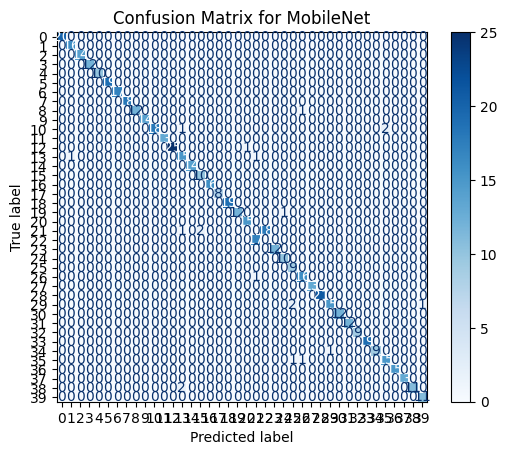

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.94      1.00      0.97        16
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        18
           8       1.00      0.92      0.96        13
           9       1.00      1.00      1.00        14
          10       1.00      0.86      0.92        21
          11       1.00      1.00      1.00        13
          12       1.00      0.96      0.98        26
          13       0.79      0.88      0.83        17
          14       1.00      1.00      1.00        14
          15       0.83      1.00      0.91        10
          16       1.00      1.00      1.00        16
    

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loaders as previously defined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetModel(num_classes=40).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "mobilenet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MobileNet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Classes = ['Aloevera', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Avacado',
           'Bamboo', 'Basale','Betel', 'Betel_Nut', 'Brahmi',
           'Castor', 'Curry_Leaf',
           'Doddapatre', 'Ekka', 'Ganike', 'Gauva', 'Geranium',
           'Henna', 'Hibiscus', 'Honge', 'Insulin',
           'Jasmine', 'Lemon', 'Lemon_grass', 'Mango', 'Mint',
           'Nagadali', 'Neem', 'Nithyapushpa', 'Nooni', 'Pappaya', 'Pepper',
           'Pomegranate', 'Raktachandini', 'Rose', 'Sapota', 'Tulasi', 'Wood_sorel']

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model class (same as the one used during training)
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Load the trained model
model = MobileNetModel(num_classes=len(Classes))  # Use the length of the Classes list for num_classes
model.load_state_dict(torch.load("/kaggle/working/mobilenet.pt"))
model = model.to(device)
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Helper function to map the prediction to class name
def get_class_name(prediction_index):
    if 0 <= prediction_index < len(Classes):
        return Classes[prediction_index]
    else:
        return "Unknown"

# Example usage
image_path = "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Betel_Nut/1688.jpg"
prediction_index = predict_image(image_path)
predicted_class_name = get_class_name(prediction_index)

print(f"The predicted class for the image is: {predicted_class_name}")


The predicted class for the image is: Amruta_Balli


/tmp/ipykernel_36/526698335.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/mobilenet.pt"))


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Define the RNN model
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x should be of shape (batch_size, sequence_length, input_dim)
        rnn_out, _ = self.rnn(x)
        # Use the output of the last time step for classification
        out = self.fc(rnn_out[:, -1, :])
        return F.log_softmax(out, dim=1)

# Define the combined model
class MobileNetRNN(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetRNN, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()

        self.feature_dim = 1280  # MobileNetV2 output feature size
        self.rnn_input_dim = 1280
        self.rnn_hidden_dim = 512
        self.rnn_output_dim = num_classes

        self.rnn = RNNClassifier(self.rnn_input_dim, self.rnn_hidden_dim, self.rnn_output_dim)

    def forward(self, x):
        # Extract features using MobileNetV2
        features = self.mobilenet(x)
        features = features.view(features.size(0), -1)  # Flatten
        features = features.unsqueeze(1)  # Add sequence dimension

        # Forward pass through RNN
        output = self.rnn(features)
        return output

# Define transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load the dataset
dataset = ImageFolder(root='/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(dataset.classes)

model = MobileNetRNN(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
best_model_path = 'best_model_rnn.pth'
best_val_loss = float('inf')

def accumulate_predictions_and_labels(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * data.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    avg_accuracy = accuracy_score(all_labels, all_preds)
    return np.array(all_labels), np.array(all_preds), avg_loss, avg_accuracy

def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    return correct / total

# Training loop
for epoch in range(15):
    model.train()
    running_loss = 0.0
    for data, targets in train_loader:
        optimizer.zero_grad()

        data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

        outputs = model(data)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = compute_accuracy(train_loader)

    # Compute validation loss and accuracy
    y_true, y_pred, val_loss, val_acc = accumulate_predictions_and_labels(val_loader)

    print(f"Epoch {epoch+1}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1}")

# Compute final metrics on validation data
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=dataset.classes)

print("Final Validation Metrics:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

print("Training complete.")


Epoch 1
Training Loss: 1.0280, Training Accuracy: 0.8650
Validation Loss: 0.5697, Validation Accuracy: 0.8116
Best model saved at epoch 1
Epoch 2
Training Loss: 0.3715, Training Accuracy: 0.8892
Validation Loss: 0.4795, Validation Accuracy: 0.8427
Best model saved at epoch 2
Epoch 3
Training Loss: 0.2436, Training Accuracy: 0.8915
Validation Loss: 0.5570, Validation Accuracy: 0.8402
Epoch 4
Training Loss: 0.2127, Training Accuracy: 0.9380
Validation Loss: 0.3424, Validation Accuracy: 0.9008
Best model saved at epoch 4
Epoch 5
Training Loss: 0.2146, Training Accuracy: 0.9104
Validation Loss: 0.5041, Validation Accuracy: 0.8553
Epoch 6
Training Loss: 0.1711, Training Accuracy: 0.9533
Validation Loss: 0.3524, Validation Accuracy: 0.9066
Epoch 7
Training Loss: 0.1221, Training Accuracy: 0.9859
Validation Loss: 0.1487, Validation Accuracy: 0.9512
Best model saved at epoch 7
Epoch 8
Training Loss: 0.1121, Training Accuracy: 0.9407
Validation Loss: 0.3306, Validation Accuracy: 0.8957
Epoch 9


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2
from PIL import Image
from torchvision import models
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Define transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
dataset = ImageFolder(root='Indian Medicinal Leaves Image Datasets/Medicinal plant dataset', transform=transform)

# Define the RNN model class and MobileNetRNN class (copy from previous notebook)
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return F.log_softmax(out, dim=1)

class MobileNetRNN(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetRNN, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()

        self.feature_dim = 1280
        self.rnn_input_dim = 1280
        self.rnn_hidden_dim = 512
        self.rnn_output_dim = num_classes

        self.rnn = RNNClassifier(self.rnn_input_dim, self.rnn_hidden_dim, self.rnn_output_dim)

    def forward(self, x):
        features = self.mobilenet(x)
        features = features.view(features.size(0), -1)
        features = features.unsqueeze(1)

        output = self.rnn(features)
        return output

# Load the model
num_classes = len(dataset.classes)  # Ensure this matches the number of classes in your dataset
model = MobileNetRNN(num_classes)
model.load_state_dict(torch.load('best_model_rnn.pth'))
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# Load the image
image_path = r'Indian Medicinal Leaves Image Datasets\Medicinal plant dataset\Tulasi\264.jpg'  # Replace with the path to your image
image = Image.open(image_path).convert('RGB')

# Apply transformations
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image = image.to(device)

# Make prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted_class = torch.max(outputs, 1)

# Map the prediction to the class label
class_names = dataset.classes  # Ensure this is the same class order as during training
predicted_label = class_names[predicted_class.item()]

print(f"Predicted label: {predicted_label}")


C:\Users\0871\AppData\Local\Temp\ipykernel_13796\1170177100.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_rnn.pth'))


Predicted label: Tulasi
